In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [3]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
%matplotlib inline
print('Librairies imported')

Importing librairies...


Using TensorFlow backend.


Librairies imported


In [20]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [21]:
df_1D = pd.read_csv('20190526 data prepared.csv')
df_1D = df_1D.iloc[:,1:]
df_1D = df_1D.dropna()
df_1D.reset_index(inplace=True,drop=True)

In [22]:
df_1D.isnull().sum().sum()

0

In [23]:
df_1D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 28 columns):
Date                  1207 non-null int64
Vix                   1207 non-null float64
P/C Ratio             1207 non-null float64
Varop_Spy             1207 non-null float64
Varhl_spy             1207 non-null float64
Varop_vix             1207 non-null float64
Varhl_vix             1207 non-null float64
RSI                   1207 non-null float64
75 - RSI              1207 non-null float64
RSI - 25              1207 non-null float64
BBD_Delta_Up          1207 non-null float64
delta5_8              1207 non-null float64
delta8_10             1207 non-null float64
delta10_12            1207 non-null float64
delta12_15            1207 non-null float64
delta15_30            1207 non-null float64
delta30_35            1207 non-null float64
delta35_40            1207 non-null float64
delta40_45            1207 non-null float64
delta45_50            1207 non-null float64
Spread         

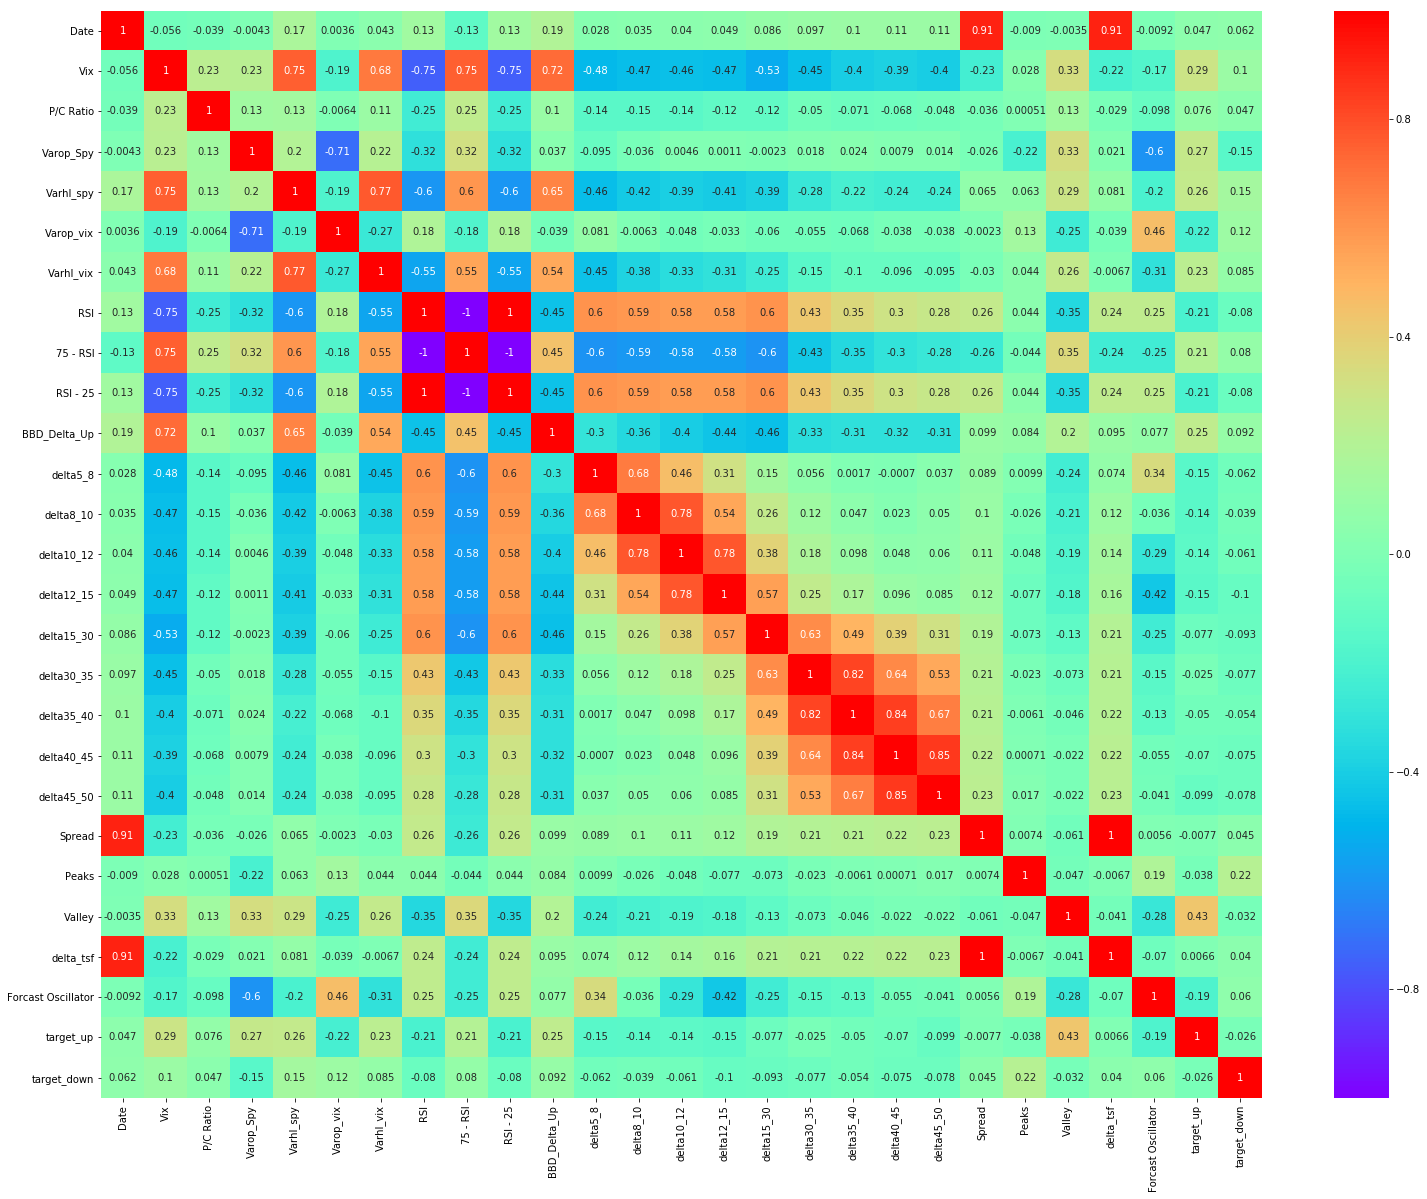

In [24]:
plt.figure(figsize=(26,20))
sns.heatmap(df_1D.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [25]:
df_1D.shape

(1207, 28)

In [26]:
df_1D['target_up'].sum(),df_1D['target_down'].sum()

(36, 26)

In [27]:
delta = round(df_1D.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_1D.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_1D.iloc[bloc2,0],')')
print('First period :',df_1D.iloc[0,0])
print('Last period :',df_1D.iloc[df_1D.shape[0]-1,0])


# of periods :  1207
On 80% - 20% slash : 
Bloc 1 :  966  periods ( 20180612 )
Bloc 2 : 241  periods ( 20150727 )
First period : 20140811
Last period : 20190528


In [28]:
X = df_1D.iloc[:,1:-4]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_1D.iloc[:,-3].values
y_down = df_1D.iloc[:,-2].values

encoder = LabelEncoder()
encoder.fit(y_up)
y_up = encoder.transform(y_up)
encoder.fit(y_down)
y_down = encoder.transform(y_down)

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 23 columns):
Vix             1207 non-null float64
P/C Ratio       1207 non-null float64
Varop_Spy       1207 non-null float64
Varhl_spy       1207 non-null float64
Varop_vix       1207 non-null float64
Varhl_vix       1207 non-null float64
RSI             1207 non-null float64
75 - RSI        1207 non-null float64
RSI - 25        1207 non-null float64
BBD_Delta_Up    1207 non-null float64
delta5_8        1207 non-null float64
delta8_10       1207 non-null float64
delta10_12      1207 non-null float64
delta12_15      1207 non-null float64
delta15_30      1207 non-null float64
delta30_35      1207 non-null float64
delta35_40      1207 non-null float64
delta40_45      1207 non-null float64
delta45_50      1207 non-null float64
Spread          1207 non-null float64
Peaks           1207 non-null int64
Valley          1207 non-null int64
delta_tsf       1207 non-null float64
dtypes: float64(21), in

In [30]:
X.iloc[:5,[6,7]]

,RSI,75 - RSI
0,45.146656,29.853344
1,44.065975,30.934025
2,49.402586,25.597414
3,52.580633,22.419367
4,52.530232,22.469768


In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [32]:
X[:5,[6,7]]

array([[0.40589373, 0.59410627],
       [0.39043778, 0.60956222],
       [0.46676223, 0.53323777],
       [0.51221479, 0.48778521],
       [0.51149396, 0.48850604]])

In [33]:
Xtrain = X[:bloc1,:]
Xtest = X[bloc1:,:]
ytrain_up = y_up[:bloc1,:]
ytest_up = y_up[bloc1:,:]
ytrain_down = y_down[:bloc1,:]
ytest_down = y_down[bloc1:,:]

In [34]:
Xtrain.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((966, 23), (966, 1), (966, 1), (241, 1), (241, 1))

In [35]:
Xtrain = Xtrain.reshape((Xtrain.shape[0],1,Xtrain.shape[1]))
Xtest = Xtest.reshape((Xtest.shape[0],1,Xtest.shape[1]))

ytrain_up = ytrain_up.reshape((ytrain_up.shape[0],1,ytrain_up.shape[1]))
ytest_up = ytest_up.reshape((ytest_up.shape[0],1,ytest_up.shape[1]))
ytrain_down = ytrain_down.reshape((ytrain_down.shape[0],1,ytrain_down.shape[1]))
ytest_down = ytest_down.reshape((ytest_down.shape[0],1,ytest_down.shape[1]))

Xtrain.shape,Xtest.shape, ytrain_up.shape , ytest_up.shape, ytrain_down.shape, ytest_down.shape

((966, 1, 23),
 (241, 1, 23),
 (966, 1, 1),
 (241, 1, 1),
 (966, 1, 1),
 (241, 1, 1))

In [19]:
n_timesteps = Xtrain.shape[0]
print('Processing move_up')
model_up = Sequential()
model_up.add(LSTM(50, input_shape=(Xtrain.shape[0],Xtrain.shape[1]), return_sequences=True))
model_up.add(TimeDistributed(Dense(1, activation='sigmoid')))
model_up.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_up.fit(Xtrain, ytrain_up, epochs=100, batch_size=32, verbose=2)
print('Processing move_down')
model_down = Sequential()
model_down.add(LSTM(50, input_shape=(Xtrain.shape[0],Xtrain.shape[1]), return_sequences=True))
model_down.add(TimeDistributed(Dense(1, activation='sigmoid')))
model_down.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_down.fit(Xtrain, ytrain_down, epochs=100, batch_size=32, verbose=2)
print('Done')

Processing move_up


ValueError: Error when checking input: expected lstm_1_input to have shape (966, 1) but got array with shape (1, 23)

In [20]:
for i in range(n_timesteps):
	print('Expected:', y[0, i], 'Predicted', yhat[0, i])

ValueError: Error when checking input: expected lstm_1_input to have shape (1, 966) but got array with shape (966, 23)

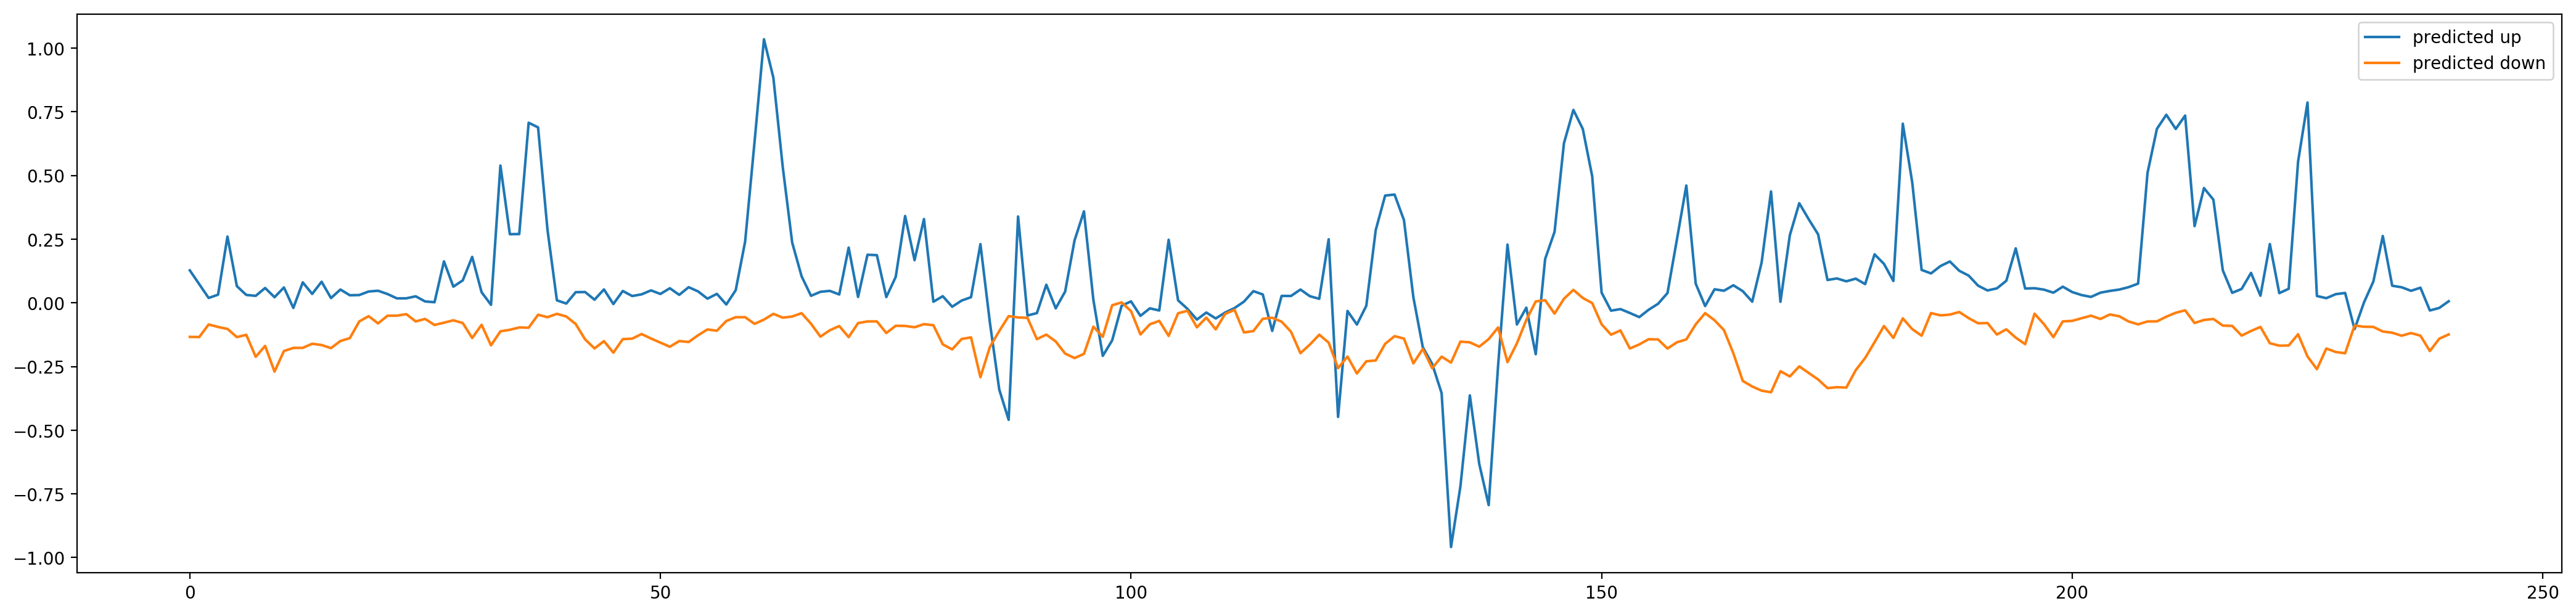

In [38]:
yhat_up = model_up.predict(Xtest)
yhat_down = model_down.predict(Xtest)

In [37]:

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [417]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 96.27%
Precision: 57.14%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 40.00%   => Positifs trouvés par Golem sur tous les positifs existants
AUC: 69.35% 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       231
           1       0.57      0.40      0.47        10

   micro avg       0.96      0.96      0.96       241
   macro avg       0.77      0.69      0.73       241
weighted avg       0.96      0.96      0.96       241

[[228   3]
 [  6   4]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [418]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 95.44%
Precision: 25.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 11.11%   => Positifs trouvés par Golem sur tous les positifs existants
AUC: 54.91% 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       232
           1       0.25      0.11      0.15         9

   micro avg       0.95      0.95      0.95       241
   macro avg       0.61      0.55      0.57       241
weighted avg       0.94      0.95      0.95       241

[[229   3]
 [  8   1]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [419]:
len(df_1D)-(len(df_1D)-241)

241

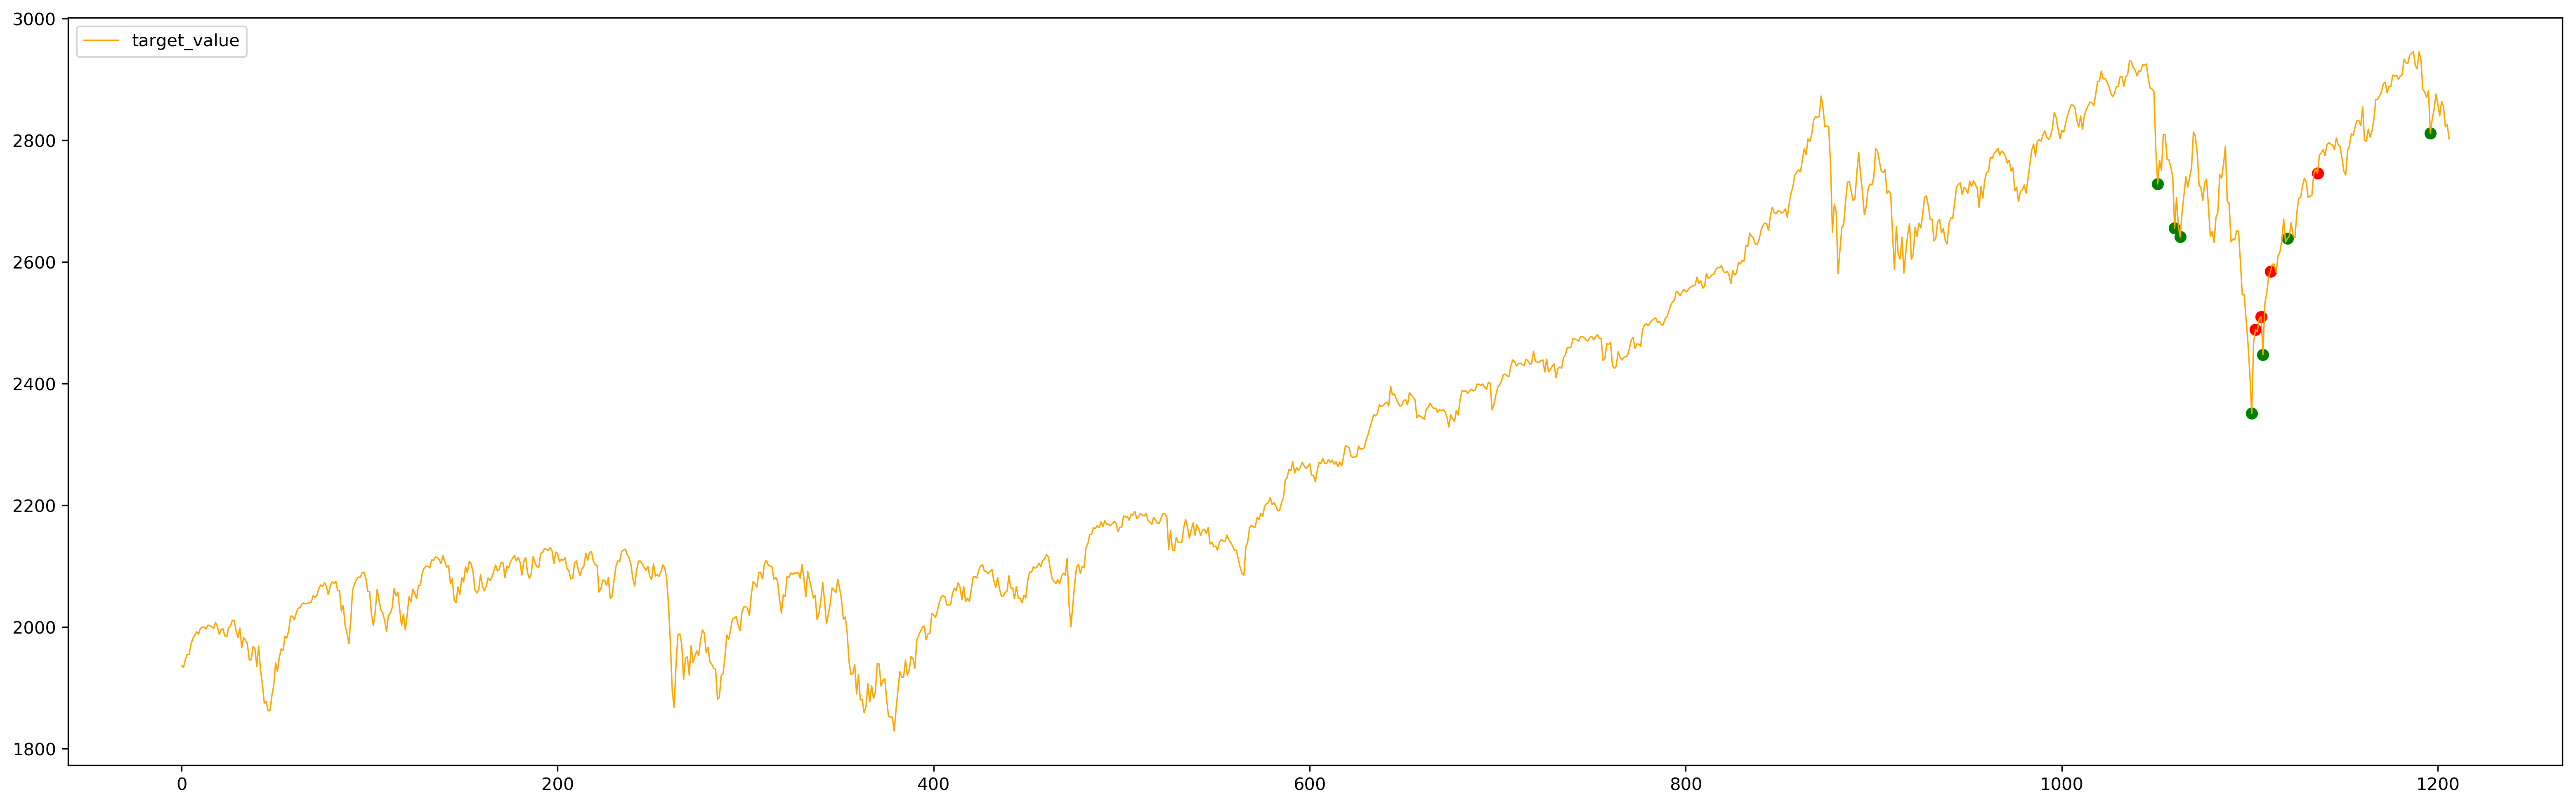

In [420]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_1D['target_value'],color='orange',lw=0.8)
a = -1
for i in range(len(df_1D)-241,len(df_1D)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='r',marker='o')
plt.legend()

In [421]:
sum(yhat_up),sum(yhat_down)

(7, 4)

In [351]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)